In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
from scipy.interpolate import interp1d
from scipy.signal import butter, filtfilt

### Load values

In [3]:
FHR = loadmat("data_FHR.mat")

f_sample = 4 # Hz
fhr = FHR["fhr"]
time = np.arange(len(fhr)).reshape(len(fhr), 1) / f_sample

### Define function for removing missing values

In [4]:
def remove_missing_values(fhr):
  """Remove missing values (equals to zero)

  Args:
    fhr (np.array): fetal heart rate signal

  Returns:
    np.array: interpolated fetal heart rate signal
  """
  mask = fhr != 0
  interp_function = interp1d(time[mask], fhr[mask], fill_value="extrapolate")
  return interp_function(time)

### Show data with missing values and without missing values

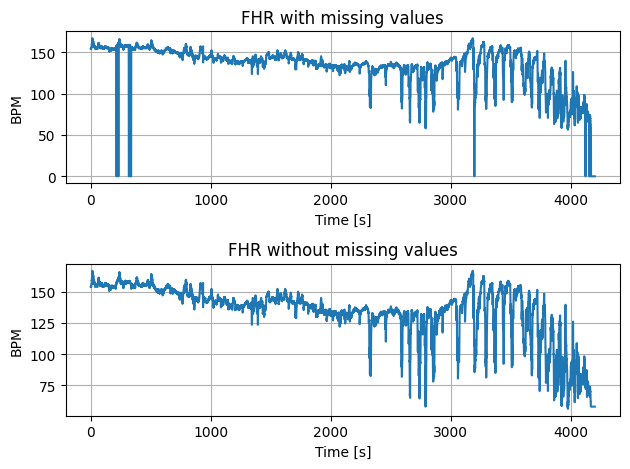

In [5]:
fhr_interpolated = remove_missing_values(fhr)

_, ax = plt.subplots(2)

# before removing missing values
ax[0].plot(time, fhr)
ax[0].set_title('FHR with missing values')
ax[0].set_xlabel('Time [s]')
ax[0].set_ylabel('BPM')
ax[0].grid(True)

# after removing missing values
ax[1].plot(time, fhr_interpolated)
ax[1].set_title('FHR without missing values')
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('BPM')
ax[1].grid(True)

plt.tight_layout()
plt.show()

### Define function for filtering the signal

In [6]:
def get_baseline(fhr, cutoff_frequency):
  """Use Butterworth IIR filter to calculate baseline of FHR signal

  Args:
    fhr (np.array): fetal heart rate signal

  Returns:
    np.array: filtered FHR signal
  """
  order = 3
  b, a = butter(order, cutoff_frequency, btype='low', analog=False)

  return filtfilt(b, a, fhr.reshape(len(fhr))).reshape(len(fhr), 1)

### Show signal and baseline in one plot

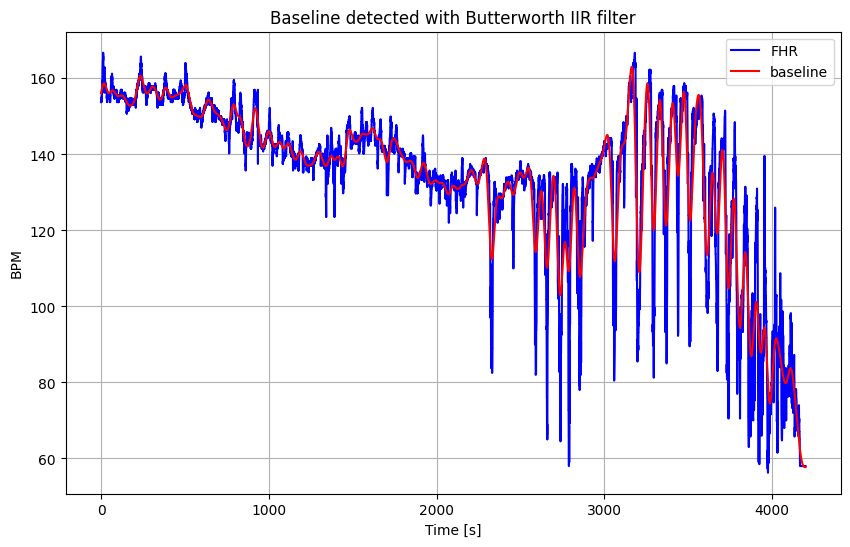

In [7]:
cutoff_frequency = 0.008 # Hz
baseline = get_baseline(fhr_interpolated, cutoff_frequency)

plt.figure(figsize=(10, 6))
plt.plot(time, fhr_interpolated, label='FHR', color='blue')
plt.plot(time, baseline, label='baseline', color='red')
plt.xlabel('Time [s]')
plt.ylabel('BPM')
plt.title("Baseline detected with Butterworth IIR filter")
plt.legend()
plt.grid(True)
plt.show()

### Define function for detect acceleration and deceleration

In [8]:
def remove_acceleration_and_deceleration(fhr, baseline, under_limit, over_limit):
  """If FHR signal exceeds over_limit for 18 seconds and more
     or FHR signal is lower than under_limit for 18 seconds and more,
     corresponding elements of FHR are set to zero.

  Args:
    fhr (numpy.array): fetal heart rate signal
    baseline (numpy.array): filtered heart rate signal
    under_limit (int): lower limit of BPM (max difference between signal and baseline)
    over_limit (int): higher limit of BPM (max difference between signal and baseline)

  Returns:
    numpy.array: fetal heart rate signal with zeroed values
  """
  fhr = fhr.copy()

  time_limit = 18  # seconds
  low = 0
  high = 0

  for i in range(len(fhr)):
    # Check for deceleration
    if fhr[i] < baseline[i] - under_limit:
      if high == 0:
        low += 1
      else:
        high = 0
    # Check for acceleration
    elif fhr[i] > baseline[i] + over_limit:
      if low == 0:
        high += 1
      else:
        low = 0
    # Reset counters
    else:
      low = 0
      high = 0

    # Zero values for deceleration
    if low >= time_limit:
      if i < len(fhr) - 1:
        fhr[i - low + 1:i + 1] = 0
      else:
        fhr[i - low + 1:] = 0

    # Zero values for acceleration
    if high >= time_limit:
      if i < len(fhr) - 1:
        fhr[i - high + 1:i + 1] = 0
      else:
        fhr[i - high + 1:] = 0

  return fhr


### Show signal without decelation and acceleration

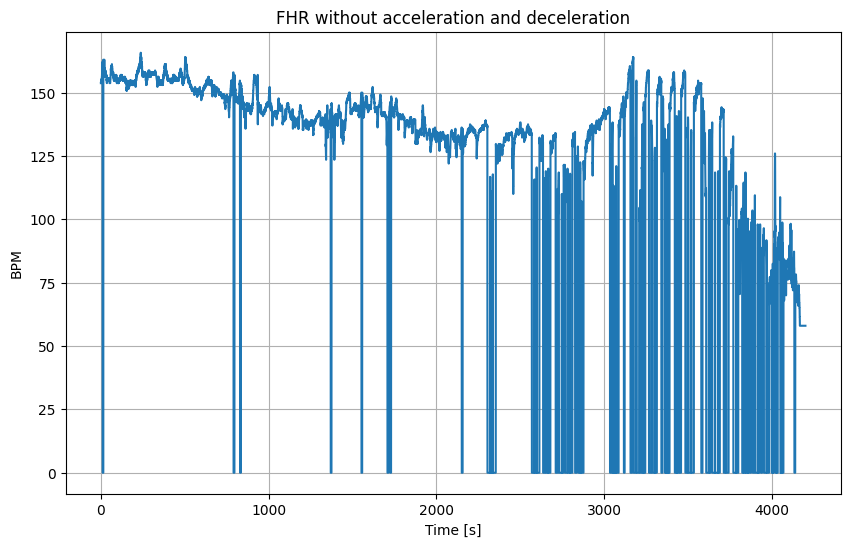

In [9]:
under_limit = 5 # BPM
over_limit = 5 # BPM
new_fhr = remove_acceleration_and_deceleration(fhr_interpolated, baseline, under_limit, over_limit)

plt.figure(figsize=(10, 6))
plt.plot(time, new_fhr)
plt.xlabel('Time [s]')
plt.ylabel('BPM')
plt.title("FHR without acceleration and deceleration")
plt.grid(True)
plt.show()

### Create loop for signal processing and plot the result

In [11]:
cutoff_frequency = 0.006  # Hz
under_limit = 5  # BPM
over_limit = 5  # BPM

baselines = []
zero_counts = []

for i in range(3):
    if i == 2:
        under_limit = 10  # BPM

    new_fhr = remove_missing_values(new_fhr)
    baseline = get_baseline(new_fhr, cutoff_frequency)
    baselines.append(baseline.copy())

    new_fhr = remove_acceleration_and_deceleration(new_fhr, baseline, under_limit, over_limit)
    zero_counts.append(np.sum(new_fhr == 0))

final_baseline = get_baseline(new_fhr, cutoff_frequency)
baselines.append(final_baseline.copy())
zero_counts.append(np.sum(new_fhr == 0))


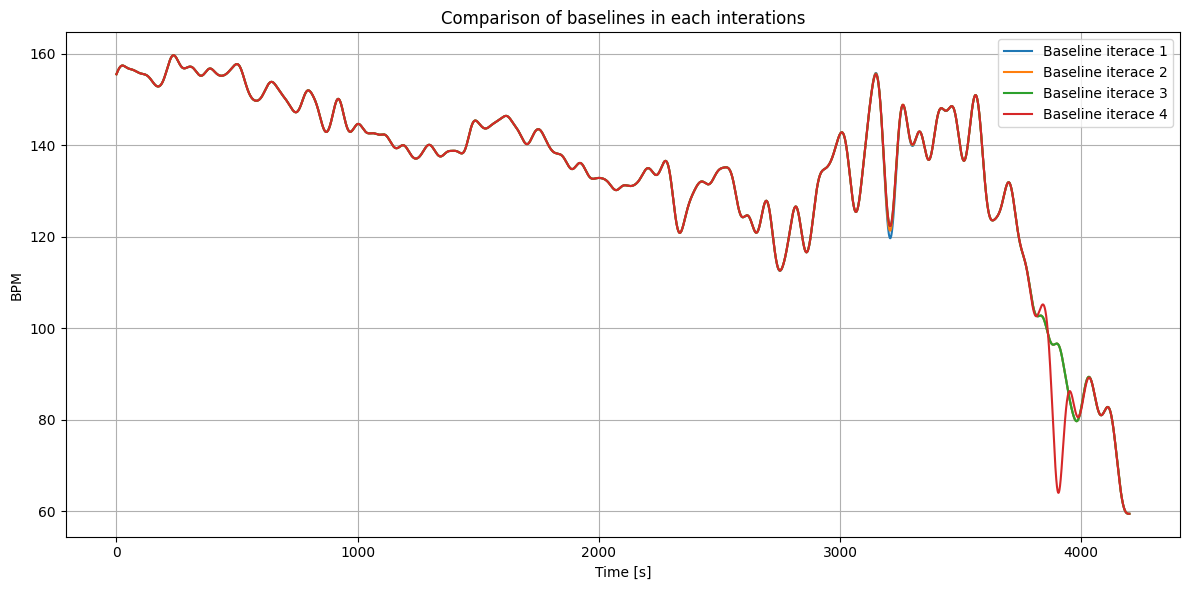

In [12]:
plt.figure(figsize=(12, 6))
for i, bl in enumerate(baselines, 1):
    plt.plot(time, bl, label=f"Baseline iterace {i}")

plt.xlabel("Time [s]")
plt.ylabel("BPM")
plt.title("Comparison of baselines in each interations")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [15]:
for i, bl in enumerate(baselines, 1):
    print(f"Iteration {i}: baseline → mean = {np.mean(bl):.2f}, min = {np.min(bl):.2f}, max = {np.max(bl):.2f}, zeros = {zero_counts[i-1]}")

Iteration 1: baseline → mean = 134.60, min = 59.45, max = 159.66, zeros = 326
Iteration 2: baseline → mean = 134.62, min = 59.45, max = 159.66, zeros = 280
Iteration 3: baseline → mean = 134.63, min = 59.45, max = 159.66, zeros = 50
Iteration 4: baseline → mean = 134.32, min = 59.45, max = 159.66, zeros = 50


### Shrnuti
- Pri kazde iteraci se zlepsoval odhad baseliny pomoci DP filtru
- Pocet nul (coz je pocet detekovanych akceleraci a deceleraci) se s kazdou iteraci snizoval
- Posledni dve iterace uz se nezmenily -> signal se stabilizoval
- Prumerna hodnota se temer nemenila pres vsechny iterace